<a href="https://colab.research.google.com/github/armandordorica/Portfolio_Optimization/blob/master/markowitz_portfolio_optimization_master_YFINANCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/My\ Drive/u\ of\ t/APS\ 1051\ Portfolio\ Optimization/Jupyter\ Notebooks/markowitz-portfolio-optimization-master.YFINANCE/

/content/drive/My Drive/u of t/APS 1051 Portfolio Optimization/Jupyter Notebooks/markowitz-portfolio-optimization-master.YFINANCE


In [3]:
ls

 figures/               markowitz_mod.pyc         README.md
 LICENSE                posdef.py                 Report.pdf
 main_mod_RUN_THIS.py   __pycache__/              StockPrices.csv
 markowitz_mod.py       README_INSTRUCTIONS.txt  'toy problem'/


In [4]:
!pip install yfinance

In [5]:
!pip install cvxpy

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


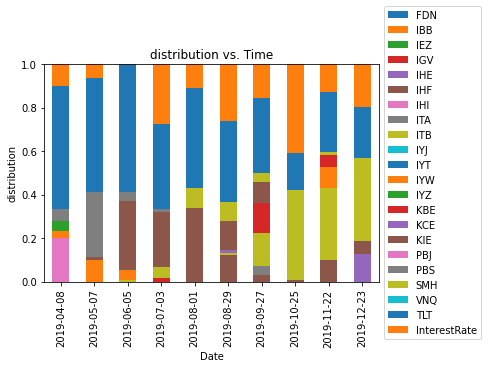

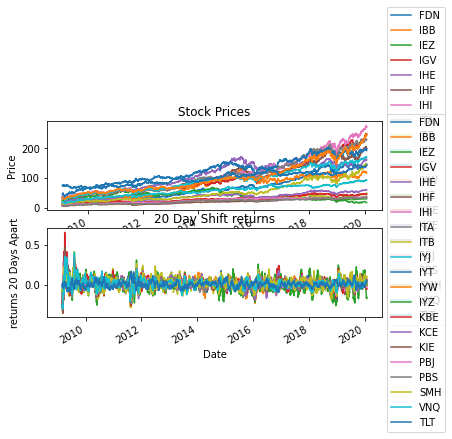

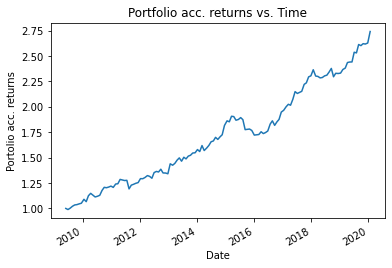

TotaAnnReturn in percent = 16.116697
CAGR in percent = 9.784572
Sharpe Ratio = 2.330000
Sharpe2 Ratio = 1.350000


In [6]:
#this program runs in Python 3.7
#markowitz portfolio, optimized by minimizing variance while stipulating a given return
#written by Chaitanya Joshi, modified by Loren Trigo

import pandas as pd
import numpy as np
from pandas import Series, DataFrame
from datetime import datetime
import matplotlib.pyplot as plt
from markowitz_mod import MarkowitzOpt

"""
StockList = ['AAPL','IBM','MSFT','GOOG','QCOM']		# Stock ticker names
# Read stock prices data
price = pd.read_csv('StockPrices.csv')
price.index = [datetime.strptime(x,'%Y-%m-%d') for x in price['Date']]
#better: price.index=pd.to_datetime(price["Date"])
price = price.drop('Date',1)
"""
#need to install:
#<py35>conda install -c anaconda pandas-datareader
#<py35>pip install yfinance
#Get the data from yahoo
pd.core.common.is_list_like = pd.api.types.is_list_like #datareader problem probably fixed in next version of datareader
from pandas_datareader import data as pdr
import datetime as dt
import yfinance as yf

yf.pdr_override() # <== that's all it takes :-)

start, end = dt.datetime(2009, 1, 30), dt.datetime(2020, 1, 30)
StockList= ["FDN","IBB","IEZ","IGV","IHE","IHF","IHI","ITA","ITB","IYJ","IYT","IYW","IYZ","KBE","KCE","KIE","PBJ","PBS","SMH","VNQ","TLT"]

price = pd.DataFrame()
for ticker in StockList:
    price[ticker]  = pdr.get_data_yahoo(ticker, start=start, end=end).loc[:,'Adj Close']

interest_rate = 0.02/12	# Fixed interest rate
min_return = 0.02			# Minimum desired return
# Specify number of days to shift
shift = 20 #shift the holding period as well as the returns period
lookback = 60

# Compute returns over the time period specified by shift
shift_returns = price/price.shift(shift) - 1

# Specify filter "length"
filter_len = lookback
# Compute mean and variance
shift_returns_mean = shift_returns.ewm(span=filter_len).mean()
shift_returns_var = shift_returns.ewm(span=filter_len).var()
# Compute covariances
NumStocks = len(StockList)
covariance = pd.DataFrame()
for FirstStock in np.arange(NumStocks-1):
    for SecondStock in np.arange(FirstStock+1,NumStocks):
        ColumnTitle = StockList[FirstStock] + '-' + StockList[SecondStock]
        covariance[ColumnTitle] = shift_returns[StockList[FirstStock]].ewm(span=filter_len).cov(shift_returns[StockList[SecondStock]].ewm(span=filter_len))

# Variable Initialization
start_date = '2009-06-01'
index = shift_returns.index
start_index = index.get_loc(start_date)
end_date = index[-1]
end_index = index.get_loc(end_date)
date_index_iter = start_index
StockList.append('InterestRate')
distribution = DataFrame(index=StockList)
returns = Series(index=index)
# Start Value
total_value = 1.0
returns[index[date_index_iter]] = total_value

while date_index_iter + shift < end_index:
	date = index[date_index_iter]
	portfolio_alloc = MarkowitzOpt(shift_returns_mean.loc[date], shift_returns_var.loc[date], covariance.loc[date], interest_rate, min_return)
	distribution[date.strftime('%Y-%m-%d')] = portfolio_alloc

	# Calculating portfolio return
	date2 = index[date_index_iter+shift]
	temp1 = price.loc[date2]/price.loc[date]
	temp1.loc[StockList[-1]] = interest_rate+1
	temp2 = Series(np.array(portfolio_alloc.ravel()).reshape(len(portfolio_alloc)),index=StockList)
	total_value = np.sum(total_value*temp2*temp1)
	# Increment Date
	date_index_iter += shift
	returns[index[date_index_iter]] = total_value

# Remove dates that there are no trades from returns
returns = returns[np.isfinite(returns)]


# Plot portfolio allocation of last 10 periods
ax = distribution.T.iloc[-10:].plot(kind='bar',stacked=True)
plt.ylim([0,1])
plt.xlabel('Date')
plt.ylabel('distribution')
plt.title('distribution vs. Time')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig('allocation.png')

# Plot stock prices and shifted returns
fig, axes = plt.subplots(nrows=2,ncols=1)
price.plot(ax=axes[0])
shift_returns.plot(ax=axes[1])
axes[0].set_title('Stock Prices')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].set_title(str(shift)+ ' Day Shift returns')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('returns ' + str(shift) + ' Days Apart')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig('stocks.png', pad_inches=1)
fig.tight_layout()

# Plot portfolio returns vs. time
plt.figure()
returns.plot()
plt.xlabel('Date')
plt.ylabel('Portolio acc. returns')
plt.title('Portfolio acc. returns vs. Time')
# plt.savefig('returns.png')

plt.show()

df = pd.DataFrame(returns, index=returns.index, columns=['I'])
df["returns"]=(df.I-df.I.shift(1))/df.I.shift(1)
start_date = df.iloc[0].name
end_date = df.iloc[-1].name
days_per_month = 30 #since .days (see below) is calendar days, need to use 30 here
months = (end_date - start_date).days/days_per_month 
periods = 12 #12 months in a year
start_val = df['I'].iat[0]
end_val = df['I'].iat[-1]
years = months/periods

CAGR = ((((end_val/start_val)**(1/years)))-1)
TotaAnnReturn = (end_val-start_val)/start_val/years

try:
    sharpe =  TotaAnnReturn/( (df.returns.std()) * np.sqrt(periods))
except ZeroDivisionError:
    sharpe = 0.0

#this is a more conservataive estimate:
try:
    sharpe2 =  (df.returns.mean()/df.returns.std()) * np.sqrt(periods)
except ZeroDivisionError:
    sharpe2 = 0.0

print ("TotaAnnReturn in percent = %f" %(TotaAnnReturn*100))
print ("CAGR in percent = %f" %(CAGR*100))
print ("Sharpe Ratio = %f" %(round(sharpe,2)))
print ("Sharpe2 Ratio = %f" %(round(sharpe2,2)))


In [6]:
ls

LICENSE               posdef.py                Report.pdf
main_mod_RUN_THIS.py  __pycache__/             sample_data/
markowitz_mod.py      README_INSTRUCTIONS.txt  StockPrices.csv
markowitz_mod.pyc     README.md
